In [1]:
import pandas as pd
import numpy as np

from datasets import load_dataset
from dlomix.models.chargestate import ChargeStateDistributionPredictor

2024-07-25 15:23:26.902295: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 15:23:26.921859: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 15:23:26.921876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 15:23:26.922234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 15:23:26.925409: I tensorflow/core/platform/cpu_feature_guar


Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



## Load data from Huggingface

In [2]:
dataset = load_dataset("Wilhelmlab/prospect-ptms-charge")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['modified_sequence', 'raw_file', 'scan_number', 'package', 'most_abundant_charge_state', 'observed_charge_states', 'charge_state_dist'],
        num_rows: 1142537
    })
    val: Dataset({
        features: ['modified_sequence', 'raw_file', 'scan_number', 'package', 'most_abundant_charge_state', 'observed_charge_states', 'charge_state_dist'],
        num_rows: 328072
    })
    test: Dataset({
        features: ['modified_sequence', 'raw_file', 'scan_number', 'package', 'most_abundant_charge_state', 'observed_charge_states', 'charge_state_dist'],
        num_rows: 161588
    })
})

In [4]:
dataset["train"].to_parquet("train.parquet")
dataset["val"].to_parquet("val.parquet")
dataset["test"].to_parquet("test.parquet")

Creating parquet from Arrow format:   0%|          | 0/1143 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/329 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/162 [00:00<?, ?ba/s]

108922584

### Convert test set to pandas dataframe (only if manipulation is needed)

In [5]:
df = dataset["test"].to_pandas()

In [6]:
df.head()

,modified_sequence,raw_file,scan_number,package,most_abundant_charge_state,observed_charge_states,charge_state_dist
0,[UNIMOD:737]-YIHNILSI-[],"[02527_BA6-TMT_TUM_HLA_6_01_01-TMT1-1h-R1, 025...","[53707, 59458, 59518]",[TMT_TUM_HLA],"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
1,[]-FHTPSNSYTAQR-[],[02208a_GC3-TUM_second_addon_27_01_01-2xIT_2xH...,"[13616, 13659, 13660, 13759, 13760, 13761, 138...",[TUM_second_addon],"[0, 0, 1, 0, 0, 0]","[0, 1, 1, 0, 0, 0]","[0.0, 0.18388216654438674, 0.8161178334556133,..."
2,[]-IPGPEGQEVLC[UNIMOD:4]KQIK-[],[01748a_BH4-TUM_second_pool_66_01_01-2xIT_2xHC...,"[21369, 21370, 21371, 21397, 21398, 21399, 214...",[TUM_second_pool],"[0, 0, 1, 0, 0, 0]","[0, 1, 1, 0, 0, 0]","[0.0, 0.03440733446425485, 0.9655926655357452,..."
3,[]-TGQK[UNIMOD:1]VALKK-[],[02195a_GA4-TUM_mod_acetylated_4_01_01-DDA-1h-...,"[9811, 9913, 9914, 10066, 10067]",[TUM_mod_acetylated],"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
4,[]-ATLC[UNIMOD:4]C[UNIMOD:4]ARPEPR-[],[01717a_BF3-TUM_second_pool_34_01_01-2xIT_2xHC...,"[8995, 8996, 8997, 9041, 9042, 9043, 9300, 935...",[TUM_second_pool],"[0, 0, 1, 0, 0, 0]","[0, 1, 1, 0, 0, 0]","[0.0, 0.007387597915967662, 0.9926124020840323..."


## Create dataset

In [7]:
from dlomix.data.charge_state import ChargeStateDataset
from dlomix.constants import PTMS_ALPHABET

In [8]:
data = ChargeStateDataset(data_source="train.parquet", val_data_source="val.parquet", test_data_source="test.parquet", sequence_column="modified_sequence", label_column="charge_state_dist", pad=True, padding_value=0, alphabet=PTMS_ALPHABET, encoding_scheme="naive-mods")

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

/mnt/c/Users/Florian/Desktop/Uni/MSc/FoPr/dlomix/src/dlomix/data/dataset.py:282: UserWarning: 
                Multiple data sources or a single non-train data source provided {'train': 'train.parquet', 'val': 'val.parquet', 'test': 'test.parquet'}, please ensure that the data sources are already split into train, val and test sets
                since no splitting will happen. If not, please provide only one data_source and set the val_ratio to split the data into train and val sets."
                
  warnings.warn(


Mapping SequenceParsingProcessor:   0%|          | 0/1142537 [00:00<?, ? examples/s]

Mapping SequenceParsingProcessor:   0%|          | 0/328072 [00:00<?, ? examples/s]

Mapping SequenceParsingProcessor:   0%|          | 0/161588 [00:00<?, ? examples/s]

Mapping SequenceEncodingProcessor:   0%|          | 0/1142537 [00:00<?, ? examples/s]

Mapping SequenceEncodingProcessor:   0%|          | 0/328072 [00:00<?, ? examples/s]

Mapping SequenceEncodingProcessor:   0%|          | 0/161588 [00:00<?, ? examples/s]

Mapping SequencePaddingProcessor:   0%|          | 0/1142537 [00:00<?, ? examples/s]

Mapping SequencePaddingProcessor:   0%|          | 0/328072 [00:00<?, ? examples/s]

Mapping SequencePaddingProcessor:   0%|          | 0/161588 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1142537 [00:00<?, ? examples/s]

Filter:   0%|          | 0/328072 [00:00<?, ? examples/s]

## Create model

In [9]:
from tensorflow.keras.optimizers import Adam

In [10]:
optimizer = Adam(learning_rate=0.0001)

2024-07-25 15:24:07.919253: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-25 15:24:07.932712: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-25 15:24:07.932745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-25 15:24:07.935219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-25 15:24:07.935248: I external/local_xla/xla/stream_executor

In [11]:
charge_distribution_model = ChargeStateDistributionPredictor(seq_length=30, vocab_dict=PTMS_ALPHABET)
charge_distribution_model.compile(optimizer=optimizer, loss='mean_absolute_error')

## Train model

In [12]:
charge_distribution_model_history = charge_distribution_model.fit(
    data.tensor_train_data, 
    validation_data=data.tensor_val_data,
    epochs=5,
)

Epoch 1/5


/root/miniforge3/envs/pcp_env/lib/python3.11/site-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
/root/miniforge3/envs/pcp_env/lib/python3.11/site-packages/datasets/utils/tf_utils.py:131: RuntimeWarning: invalid value encountered in cast
  array = array.astype(cast_dtype)
2024-07-25 15:24:10.891685: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-07-25 15:24:11.325924: I external/local_xla/xla/service/service.cc

4446/4446 [==============================] - 187s 41ms/step - loss: 0.0529 - val_loss: 0.0350
Epoch 2/5
3321/4446 [=====================>........] - ETA: 41s - loss: 0.0347

### Train History

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_learning_curves(history, title='Learning Curves'):
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict.get('val_loss', [])
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

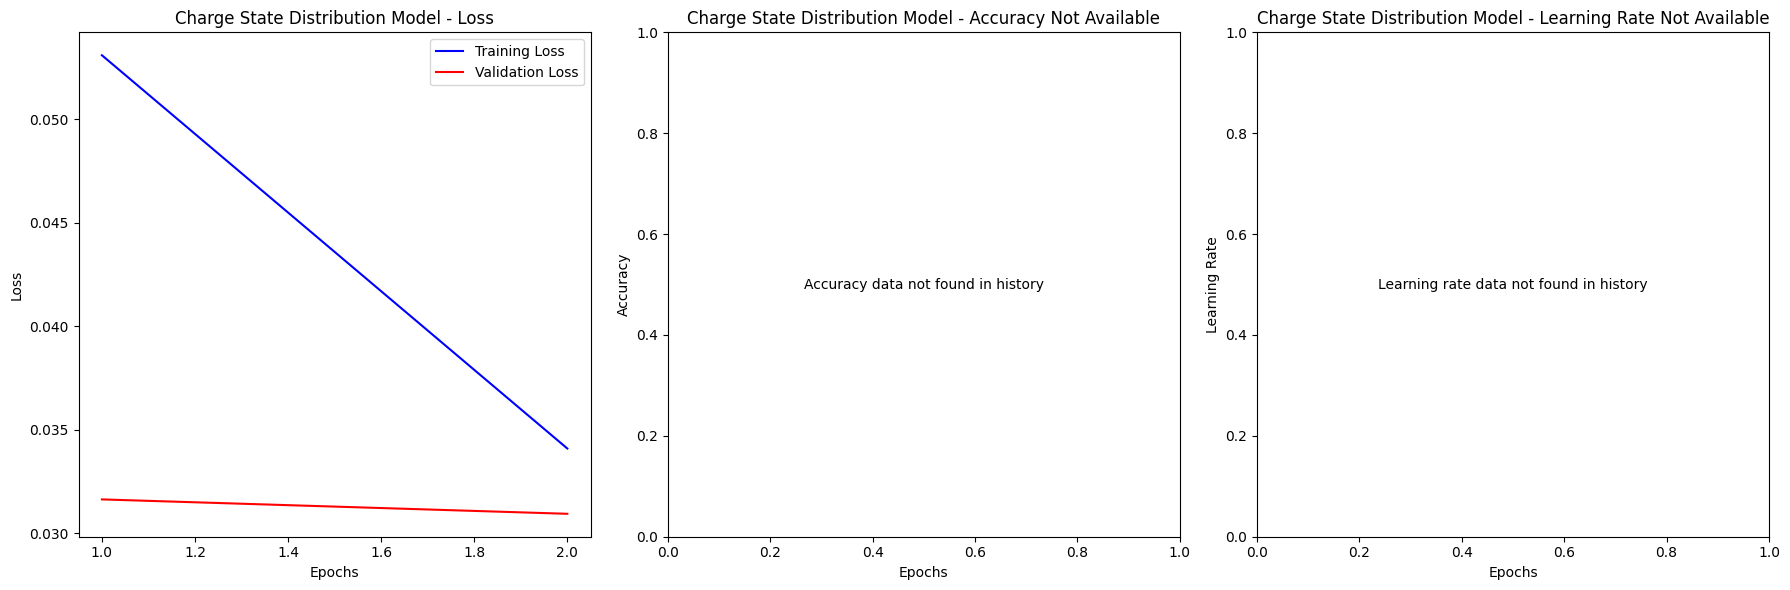

In [ ]:
plot_learning_curves(charge_distribution_model_history, title='Charge State Distribution Model')